<a href="https://colab.research.google.com/github/LukmanovaLiliya/-Python-Data-Science-/blob/LukmanovaLiliya-patch-1/%D0%9A%D1%83%D1%80%D1%81%D0%BE%D0%B2%D0%BE%D0%B9_%D0%BF%D1%80%D0%BE%D0%B5%D0%BA%D1%82_%D0%BF%D0%BE_%D0%BA%D1%83%D1%80%D1%81%D1%83_%22%D0%91%D0%B8%D0%B1%D0%BB%D0%B8%D0%BE%D1%82%D0%B5%D0%BA%D0%B8_Python_%D0%B4%D0%BB%D1%8F_Data_Science_Numpy%2C_Matplotlib%2C_Scikit_learn%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Прогноз цен на недвижимость

Задание для курсового проекта Метрика: R2 - коэффициент детерминации (sklearn.metrics.r2_score)

Сдача проекта:

Сдать проект нужно в течение 7 дней после окончания последнего вебинара. Прислать в раздел Задания Урока 10 ("Вебинар. Консультация по итоговому проекту") ссылку на ноутбук в github или public kaggle notebook. Необходимо получить R2 > 0.6 на Private Leaderboard. Укажите свой ник на kaggle Примечание: Все файлы csv должны содержать названия полей (header - то есть "шапку"),разделитель - запятая. В файлах не должны содержаться индексы из датафрейма.

Рекомендации для файла с кодом (ipynb):

Файл должен содержать заголовки и комментарии Повторяющиеся операции лучше оформлять в виде функций По возможности добавлять графики, описывающие данные (около 3-5) Добавлять только лучшую модель, то есть не включать в код все варианты решения проекта Скрипт проекта должен отрабатывать от начала и до конца (от загрузки данных до выгрузки предсказаний) Весь проект должен быть в одном скрипте (файл ipynb). При использовании статистик (среднее, медиана и т.д.) в качестве признаков, лучше считать их на трейне, и потом на валидационных и тестовых данных не считать статистики заново, а брать их с трейна. Проект должен полностью отрабатывать за разумное время (не больше 10 минут), поэтому в финальный вариант лучше не включать GridSearch с перебором большого количества сочетаний параметров.

План занятия

Загрузка данных

1. EDA 
2. Обработка выбросов
3. Обработка пропусков
4. Построение новых признаков
5. Отбор признаков
6.Разбиение на train и test
7.Построение модели
8. Прогнозирование на тестовом датасете

Подключение библиотек и скриптов


In [ ]:

# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [ ]:

import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

import datetime

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})
def evaluate_preds(train_true_values, train_pred_values, test_true_values, test_pred_values):
    print("Train R2:\t" + str(round(r2(train_true_values, train_pred_values), 3)))
    print("Test R2:\t" + str(round(r2(test_true_values, test_pred_values), 3)))
    
    plt.figure(figsize=(18,10))
    
    plt.subplot(121)
    sns.scatterplot(x=train_pred_values, y=train_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Train sample prediction')
    
    plt.subplot(122)
    sns.scatterplot(x=test_pred_values, y=test_true_values)
    plt.xlabel('Predicted values')
    plt.ylabel('True values')
    plt.title('Test sample prediction')

    plt.show()

Загружаем данные train и test



Id - идентификационный номер квартиры

DistrictId - идентификационный номер района

Rooms - количество комнат

Square - площадь

LifeSquare - жилая площадь

KitchenSquare - площадь кухни

Floor - этаж

HouseFloor - количество этажей в доме

HouseYear - год постройки дома

Ecology_1, Ecology_2, Ecology_3 - экологические показатели местности

Social_1, Social_2, Social_3 - социальные показатели местности

Healthcare_1, Helthcare_2 - показатели местности, связанные с охраной здоровья

Shops_1, Shops_2 - показатели, связанные с наличием магазинов, торговых центров

Price - цена квартиры рабочий стол

In [ ]:
TRAIN_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/train.csv'
TEST_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/test.csv'
SAMPLE_SUBMISSION_DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/sample_submission.csv'

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
train_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,1260,61,2.0,49.090728,33.272626,6.0,3,12.0,1981,0.300323,B,B,52,10311,6,NaN,1,9,B,119367.455796
9996,16265,27,2.0,64.307684,37.038420,9.0,13,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A,199715.148807
9997,2795,178,1.0,29.648057,16.555363,5.0,3,5.0,1958,0.460556,B,B,20,4386,14,NaN,1,5,B,165953.912580
9998,14561,21,1.0,32.330292,22.326870,5.0,3,9.0,1969,0.194489,B,B,47,8004,3,125.0,3,5,B,171842.411855
9999,7202,94,1.0,35.815476,22.301367,6.0,9,9.0,1975,0.127376,B,B,43,8429,3,NaN,3,9,B,177685.627486


# 1. EDA

Делаем EDA для:


Исправления выбросов

Заполнения NaN

Идей для генерации новых фич

Целевая переменная

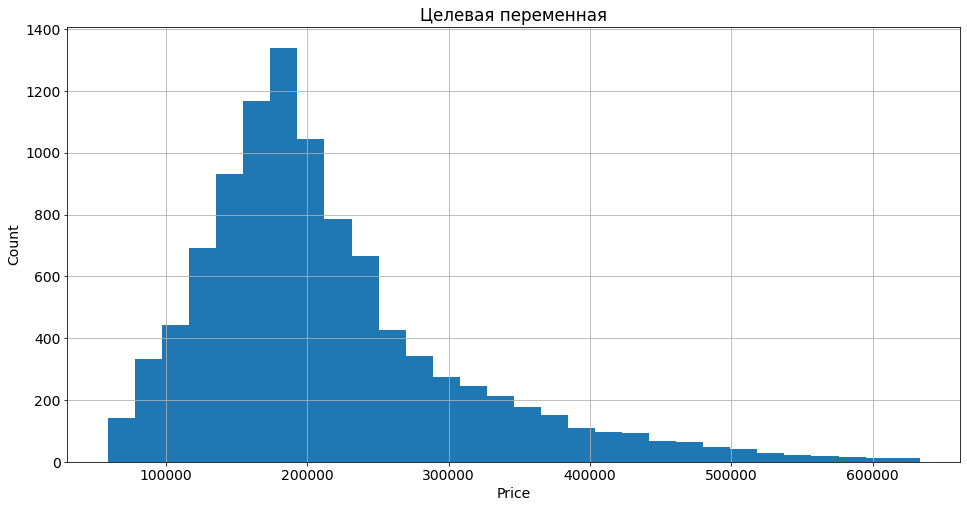

In [ ]:
plt.figure(figsize=(16,8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Целевая переменная')
plt.show()

Похоже, что выбросов нет,нет хвостов

Количественные переменные


In [ ]:
train_df.describe()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Price
count,10000.00000,10000.000000,10000.000000,10000.000000,7887.000000,10000.000000,10000.000000,10000.000000,1.000000e+04,10000.000000,10000.000000,10000.000000,10000.000000,5202.000000,10000.000000,10000.000000,10000.000000
mean,8383.40770,50.400800,1.890500,56.315775,37.199645,6.273300,8.526700,12.609400,3.990166e+03,0.118858,24.687000,5352.157400,8.039200,1142.904460,1.319500,4.231300,214138.857399
std,4859.01902,43.587592,0.839512,21.058732,86.241209,28.560917,5.241148,6.775974,2.005003e+05,0.119025,17.532614,4006.799803,23.831875,1021.517264,1.493601,4.806341,92872.293865
min,0.00000,0.000000,0.000000,1.136859,0.370619,0.000000,1.000000,0.000000,1.910000e+03,0.000000,0.000000,168.000000,0.000000,0.000000,0.000000,0.000000,59174.778028
25%,4169.50000,20.000000,1.000000,41.774881,22.769832,1.000000,4.000000,9.000000,1.974000e+03,0.017647,6.000000,1564.000000,0.000000,350.000000,0.000000,1.000000,153872.633942
50%,8394.50000,36.000000,2.000000,52.513310,32.781260,6.000000,7.000000,13.000000,1.977000e+03,0.075424,25.000000,5285.000000,2.000000,900.000000,1.000000,3.000000,192269.644879
75%,12592.50000,75.000000,2.000000,65.900625,45.128803,9.000000,12.000000,17.000000,2.001000e+03,0.195781,36.000000,7227.000000,5.000000,1548.000000,2.000000,6.000000,249135.462171
max,16798.00000,209.000000,19.000000,641.065193,7480.592129,2014.000000,42.000000,117.000000,2.005201e+07,0.521867,74.000000,19083.000000,141.000000,4849.000000,6.000000,23.000000,633233.466570


Мы видим, что пропуски точно есть в LifeSquare и Healthcare_1. Возможные выбросы в Rooms, Square, LifeSquare, HouseYear, Social_3 и Healthcare_1, тк значение средней отличается от медианы (квантиль 50%) Также есть странные значения min и max в Rooms (студии?), Square, LifeSquare, KitchenSquare, HouseFloor

Номинативные переменные

In [ ]:
train_df.select_dtypes(include='object').columns.tolist()

['Ecology_2', 'Ecology_3', 'Shops_2']

## **2. Обработка выбросов и пропусков**

In [ ]:
class DataPreprocessing:
    """Подготовка исходных данных"""

    def __init__(self):
        """Параметры класса"""
        self.medians=None
        self.kitchen_square_quantile = None
        
    def fit(self, X):
        """Сохранение статистик"""       
        # Расчет медиан
        self.medians = X.median()
        self.kitchen_square_quantile = X['KitchenSquare'].quantile(.975)
    
    # корректировка типов данных
    def opti_types(self, X):
        
        X['Rooms'] = X['Rooms'].astype(np.int8)
        X['KitchenSquare'] = X['KitchenSquare'].astype(np.int8)
        X['Floor'] = X['Floor'].astype(np.int8)
        X['HouseFloor'] = X['HouseFloor'].astype(np.int8)
        X['HouseYear'] = X['HouseYear'].astype(int)
        X['KitchenSquare'] = X['KitchenSquare'].astype(np.int8)
        X['Floor'] = X['Floor'].astype(np.int8)
        X['HouseFloor'] = X['HouseFloor'].astype(np.int8)
        X['HouseYear'] = X['HouseYear'].astype(int)
        X['Ecology_2'] = X['Ecology_2'].astype('category')
        X['Ecology_3'] = X['Ecology_3'].astype('category')
        X['Social_1'] = X['Social_1'].astype(np.int8)
        X['Social_2'] = X['Social_2'].astype(np.int)
        X['Social_3'] = X['Social_3'].astype(np.int8)
        X['Helthcare_2'] = X['Helthcare_2'].astype(np.int8)
        X['Shops_1'] = X['Shops_1'].astype(np.int8)
        X['Shops_2'] = X['Shops_2'].astype('category')
        
        return X
    
    def transform(self, X):
        """Трансформация данных"""

        # Rooms
        # Все что до 5 комнат считаем нормой. Выше - выбросы
        X['Rooms_outlier'] = 0
        X.loc[(X['Rooms'] == 0) | (X['Rooms'] >= 6), 'Rooms_outlier'] = 1
        
        X.loc[X['Rooms'] == 0, 'Rooms'] = 1
        X.loc[X['Rooms'] >= 6, 'Rooms'] = self.medians['Rooms']
        
        # KitchenSquare
        condition = (X['KitchenSquare'].isna()) \
                    | (X['KitchenSquare'] > self.kitchen_square_quantile)
        
        X.loc[condition, 'KitchenSquare'] = self.medians['KitchenSquare']

        X.loc[X['KitchenSquare'] < 3, 'KitchenSquare'] = 3
        
        # HouseFloor, Floor
        X['HouseFloor_outlier'] = 0
        X.loc[X['HouseFloor'] == 0, 'HouseFloor_outlier'] = 1
        X.loc[X['Floor'] > X['HouseFloor'], 'HouseFloor_outlier'] = 1
        
        X.loc[X['HouseFloor'] == 0, 'HouseFloor'] = self.medians['HouseFloor']
      
            
        # HouseYear
        current = datetime.date.today()
        current_year = current.year
          
        X['HouseYear_outlier'] = 0
        X.loc[X['HouseYear'] > current_year, 'HouseYear_outlier'] = 1
        X.loc[X['HouseYear'] > current_year, 'HouseYear'] = current_year


        # Healthcare_1
        if 'Healthcare_1' in X.columns:
            X.drop('Healthcare_1', axis=1, inplace=True)
            
        # LifeSquare
        X['LifeSquare_outlier'] = 0
        X.loc[(X['LifeSquare'] <= 8 ) | (X['LifeSquare'] >= 85), 'LifeSquare'] = 1
        X.loc[train_df['LifeSquare'] <= 8, 'LifeSquare'] = 8
        X.loc[train_df['LifeSquare'] >= 85 , 'LifeSquare'] = self.medians['LifeSquare']
        X['LifeSquare_nan'] = X['LifeSquare'].isna() * 1
        condition = (X['LifeSquare'].isna()) & \
                      (~X['Square'].isna()) & \
                      (~X['KitchenSquare'].isna())
        
        X.loc[condition, 'LifeSquare'] = X.loc[condition, 'Square'] - X.loc[condition, 'KitchenSquare'] - 3
      
        
        X.fillna(self.medians, inplace=True)
        
        return X

In [ ]:


def floor_to_cat(X):

    X['floor_cat'] = 0

    X.loc[X['Floor'] <= 3, 'floor_cat'] = 1  
    X.loc[(X['Floor'] > 3) & (X['Floor'] <= 5), 'floor_cat'] = 2
    X.loc[(X['Floor'] > 5) & (X['Floor'] <= 9), 'floor_cat'] = 3
    X.loc[(X['Floor'] > 9) & (X['Floor'] <= 15), 'floor_cat'] = 4
    X.loc[X['Floor'] > 15, 'floor_cat'] = 5

    return X


def year_to_cat(X):

    X['year_cat'] = 0

    X.loc[X['HouseYear'] <= 1941, 'year_cat'] = 1
    X.loc[(X['HouseYear'] > 1941) & (X['HouseYear'] <= 1945), 'year_cat'] = 2
    X.loc[(X['HouseYear'] > 1945) & (X['HouseYear'] <= 1980), 'year_cat'] = 3
    X.loc[(X['HouseYear'] > 1980) & (X['HouseYear'] <= 2000), 'year_cat'] = 4
    X.loc[(X['HouseYear'] > 2000) & (X['HouseYear'] <= 2010), 'year_cat'] = 5
    X.loc[(X['HouseYear'] > 2010), 'year_cat'] = 6

    return X

# **4. Построение новых признаков**

In [ ]:
class FeatureGenetator():
    """Генерация новых фич"""
    
    def __init__(self):
        self.DistrictId_counts = None
        self.binary_to_numbers = None
        self.house_year_max = None
        self.floor_max = None
        self.district_size = None

    def fit(self, X, y=None):
        
        X = X.copy()
        
        # Binary features
        self.binary_to_numbers = {'A': 0, 'B': 1}
        
        # DistrictID
        self.district_size = X['DistrictId'].value_counts().reset_index() \
                               .rename(columns={'index':'DistrictId', 'DistrictId':'DistrictSize'})
                
        # Target encoding
        ## District, Rooms
        df = X.copy()
        
                    
        ## floor, year
        if y is not None:
            self.floor_max = df['Floor'].max()
            self.house_year_max = df['HouseYear'].max()
            df['Price'] = y.values
            df = self.floor_to_cat(df)
            df = self.year_to_cat(df)
        

        
    def transform(self, X):
        
        # Binary features
        X['Ecology_2'] = X['Ecology_2'].map(self.binary_to_numbers)  # self.binary_to_numbers = {'A': 0, 'B': 1}
        X['Ecology_3'] = X['Ecology_3'].map(self.binary_to_numbers)
        X['Shops_2'] = X['Shops_2'].map(self.binary_to_numbers)
        
        # DistrictId, IsDistrictLarge
        X = X.merge(self.district_size, on='DistrictId', how='left')
        
        X['new_district'] = 0
        X.loc[X['DistrictSize'].isna(), 'new_district'] = 1
        
        X['DistrictSize'].fillna(5, inplace=True)
        
        X['IsDistrictLarge'] = (X['DistrictSize'] > 100).astype(int)
        
       
        return X
    
    def floor_to_cat(self, X):
        bins = [0, 3, 5, 9, 15, self.floor_max]
        X['floor_cat'] = pd.cut(X['Floor'], bins=bins, labels=False)

        X['floor_cat'].fillna(-1, inplace=True) 
        return X
     
    def year_to_cat(self, X):
        bins = [0, 1941, 1945, 1980, 2000, 2010, self.house_year_max]
        X['year_cat'] = pd.cut(X['HouseYear'], bins=bins, labels=False)

        X['year_cat'].fillna(-1, inplace=True)
        return X
 

# **5*. Отбор признаков **

In [ ]:
train_df.columns.tolist()

['Id',
 'DistrictId',
 'Rooms',
 'Square',
 'LifeSquare',
 'KitchenSquare',
 'Floor',
 'HouseFloor',
 'HouseYear',
 'Ecology_1',
 'Ecology_2',
 'Ecology_3',
 'Social_1',
 'Social_2',
 'Social_3',
 'Healthcare_1',
 'Helthcare_2',
 'Shops_1',
 'Shops_2',
 'Price']

In [ ]:
feature_names = ['Rooms', 'Square', 'LifeSquare', 'KitchenSquare', 'Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_2', 'Ecology_3', 'Social_1', 'Social_2', 'Social_3',
                 'Helthcare_2', 'Shops_1', 'Shops_2', 'Rooms_outlier']
                  

new_feature_names = ['HouseFloor_outlier',
                     'LifeSquare_nan',
                     'DistrictSize', 
                     'new_district', 
                     'IsDistrictLarge']

target_name = 'Price'

# **6. Разбиение на train и test**

In [ ]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

X = train_df.drop(columns=target_name)
y = train_df[target_name]

In [ ]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=19)

In [ ]:
preprocessor = DataPreprocessing()
preprocessor.fit(X_train)

X_train = preprocessor.transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_df = preprocessor.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape


((6700, 23), (3300, 23), (5000, 23))

In [ ]:
features_gen = FeatureGenetator()
features_gen.fit(X_train, y_train)

X_train = features_gen.transform(X_train)
X_valid = features_gen.transform(X_valid)
test_df = features_gen.transform(test_df)

X_train.shape, X_valid.shape, test_df.shape

((6700, 26), (3300, 26), (5000, 26))

In [ ]:
X_train = X_train[feature_names + new_feature_names]
X_valid = X_valid[feature_names + new_feature_names]
test_df = test_df[feature_names + new_feature_names]

In [ ]:
X_train.isna().sum().sum(), X_valid.isna().sum().sum(), test_df.isna().sum().sum()

(0, 0, 0)

# **7. Построение модели**


In [ ]:
gb_model = GradientBoostingRegressor(criterion='mse',
                                     max_depth=10,
                                     min_samples_leaf=50,
                                     random_state=42,  
                                     n_estimators=100, 
                                     max_features='log2', 
                                     loss='huber')
                                              

gb_model.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='mse', init=None,
                          learning_rate=0.1, loss='huber', max_depth=10,
                          max_features='log2', max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=50, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=42, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)

Train R2:	0.831
Test R2:	0.733


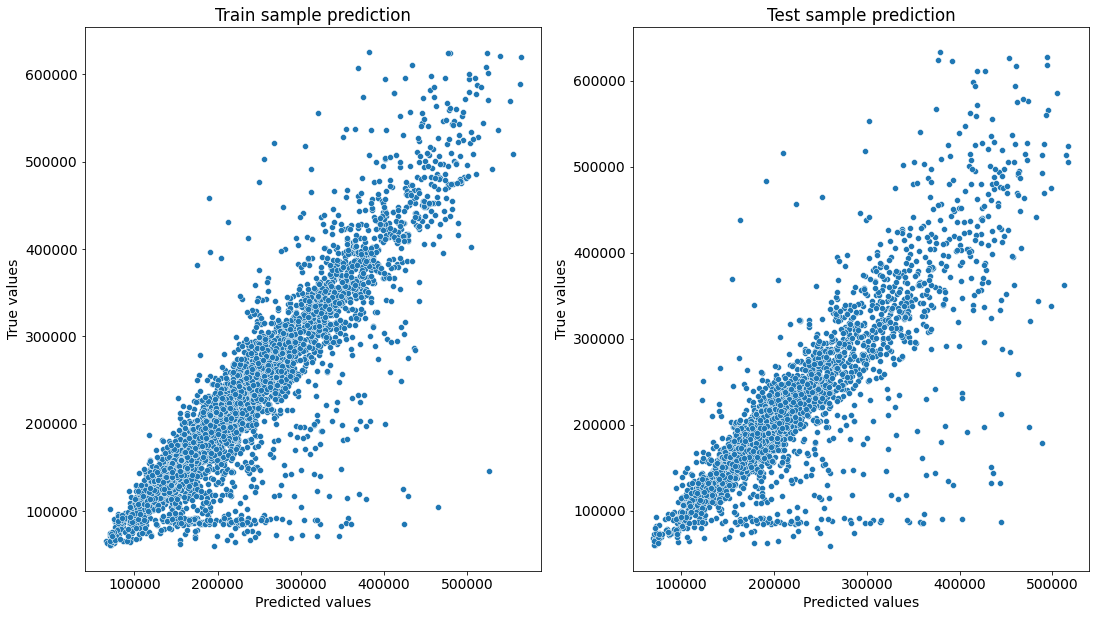

In [ ]:
y_train_preds = gb_model.predict(X_train)
y_test_preds = gb_model.predict(X_valid)


evaluate_preds(y_train, y_train_preds, y_valid, y_test_preds)

Кросс-валидация

In [ ]:
cv_score = cross_val_score(gb_model, X_train, y_train, scoring='r2', cv=KFold(n_splits=3, shuffle=True, random_state=42))
cv_score

array([0.73056745, 0.76811331, 0.72955752])

In [ ]:
cv_score.mean()

0.7427460929832733

`Важность признаков`

In [ ]:
feature_importances = pd.DataFrame(zip(X_train.columns, gb_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])
feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
1,Square,0.304076
0,Rooms,0.128603
11,Social_2,0.082399
19,DistrictSize,0.079153
10,Social_1,0.073174
2,LifeSquare,0.062080
12,Social_3,0.050185
3,KitchenSquare,0.036739
21,IsDistrictLarge,0.036340
6,HouseYear,0.035987


In [ ]:
submit = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission.csv')
submit.head()

,Id,Price
0,4567,200000.0
1,5925,200000.0
2,960,200000.0
3,3848,200000.0
4,746,200000.0


In [ ]:
predictions = gb_model.predict(test_df)
predictions

array([161174.96329928, 125479.24814467, 145591.98364778, ...,
       145667.60476784, 192321.11993354, 285598.70276032])

# **8. Прогнозирование на тестовом датасете**

In [ ]:
submit['Price'] = predictions
submit.head()

,Id,Price
0,4567,161174.963299
1,5925,125479.248145
2,960,145591.983648
3,3848,125904.963585
4,746,232999.477732


In [ ]:
submit.to_csv('rf_submit.csv', index=False)